In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

from scipy.optimize import least_squares


In [2]:
# Function to read .cam file and extract translation vector and rotation matrix
def read_cam_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Extract translation vector and rotation matrix from the first line
        first_line = list(map(float, lines[0].split()))
        translation_vector = np.array(first_line[:3])
        rotation_matrix = np.array(first_line[3:]).reshape(3, 3)
    return translation_vector, rotation_matrix

# Get all .cam files in the current folder
cam_files = [f for f in os.listdir('.') if f.endswith('.cam')]

# Separate L and R files
l_files = sorted([f for f in cam_files if '_L' in f])
r_files = sorted([f for f in cam_files if '_R' in f])

# Arrays to store rotation vectors
rotation_vectors_L = []
rotation_vectors_R = []

rotation_matrix_L=[]
rotation_matrix_R=[]
# Process L files
for l_file in l_files:
    _, rotation_matrix = read_cam_file(l_file)
    # Convert rotation matrix to rotation vector
    rotation_matrix_L.append(rotation_matrix)
    
    rotation_vector = R.from_matrix(rotation_matrix.T).as_rotvec()
    rotation_vectors_L.append(rotation_vector)

# Process R files
for r_file in r_files:
    _, rotation_matrix = read_cam_file(r_file)
    rotation_matrix_R.append(rotation_matrix)
    # Convert rotation matrix to rotation vector
    rotation_vector = R.from_matrix(rotation_matrix.T).as_rotvec()
    rotation_vectors_R.append(rotation_vector)

# Convert to numpy arrays
rotation_vectors_L = np.array(rotation_vectors_L)
rotation_vectors_R = np.array(rotation_vectors_R)

rotation_matrix_L=np.array(rotation_matrix_L)
rotation_matrix_R=np.array(rotation_matrix_R)

In [3]:
def residuals(params, R_0):
    N = R_0.shape[0]  # Number of cameras
    a, b = params[:2]  # Linear combination parameters
    phi, theta = params[2:4]  # Unit vector parameters for e
    Rot = params[4:]  # Rotation angles for each camera

    # Compute the unit vector e (axis of second rotation)
    e = phi_to_e(phi, theta)

    # Orthonormal basis vectors u and v orthogonal to e
    u, v = orthonormal_basis(e)

    # Compute r0 as a linear combination of u and v
    r0 = a * u + b * v

    residuals = []

    for i in range(N):
        R_i = R_0[i]

        # Compute the second rotation r1
        r1 = R.from_rotvec(e * Rot[i])

        # Combine rotations: r3 = r1 * r0
        r0_rotation = R.from_rotvec(r0)
        r3 = r1 * r0_rotation

        pred = r3.as_rotvec()

        residuals.append(R_i - pred)

    return np.array(residuals).flatten()

def phi_to_e(phi, theta):
    """
    Compute the unit vector e from spherical coordinates phi and theta.
    """
    e1 = np.sin(phi) * np.cos(theta)
    e2 = np.sin(phi) * np.sin(theta)
    e3 = np.cos(phi)
    return np.array([e1, e2, e3])

def orthonormal_basis(e):
    """
    Compute two orthonormal basis vectors u and v in the plane orthogonal to e.
    """
    # Choose an arbitrary vector not parallel to e
    arbitrary = np.array([1, 0, 0]) if np.abs(e[0]) < 0.9 else np.array([0, 1, 0])

    # Compute u: orthogonal to e
    u = np.cross(e, arbitrary)
    u /= np.linalg.norm(u)

    # Compute v: orthogonal to both e and u
    v = np.cross(e, u)
    v /= np.linalg.norm(v)

    return u, v

# Example usage:

# Initial guesses for parameters
a_init, b_init = 0.0, 0.0
phi_init, theta_init = np.pi / 4, np.pi / 4
Rot_init = np.ones(rotation_vectors_L.shape[0])

params_init = np.hstack(([a_init, b_init, phi_init, theta_init], Rot_init))

# Optimize for rotation vectors R_L
result_L = least_squares(
    residuals,
    params_init,
    args=(rotation_vectors_L,),
    method='trf',
    bounds=(-2 * np.pi, 2 * np.pi)
)

# Optimize for rotation vectors R_R
result_R = least_squares(
    residuals,
    params_init,
    args=(rotation_vectors_R,),
    method='trf',
    bounds=(-2 * np.pi, 2 * np.pi)
)



a_R, b_R = result_R.x[:2]
phi_R, theta_R = result_R.x[2:4]
Rot_R = result_R.x[4:]
e_R = phi_to_e(phi_R,theta_R)




a_L, b_L = result_L.x[:2]
phi_L, theta_L= result_L.x[2:4]
Rot_L= result_L.x[4:]
e_L = phi_to_e(phi_L,theta_L)






In [4]:
# # Plot the rotation vectors in 3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot L vectors
# # ax.quiver(
# #     np.zeros(len(rotation_vectors_R)), np.zeros(len(rotation_vectors_R)), np.zeros(len(rotation_vectors_R)),
# #     rotation_vectors_R[:, 0], rotation_vectors_R[:, 1], rotation_vectors_R[:, 2],
# #     color='blue', label='L Images'
# # )

# # Plot R vectors
# ax.quiver(
#     0, 0, 0,e_R[0], e_R[1], e_R[2],color='red', label='R Images'
# )


# ax.quiver(
#     0, 0, 0,e_L[0], e_L[1], e_L[2],color='blue', label='R Images'
# )
# # Add labels and legend
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.legend()
# ax.set_title('Rotation Vectors for L and R Images')

# # Show the plot
# plt.show()

In [5]:
e_R

array([-1.61372444e-04,  9.99999919e-01,  3.69886447e-04])

In [6]:
e_L

array([-0.02719139,  0.9993857 , -0.0221098 ])

In [7]:
a_R, b_R

(0.00011571066204838308, 0.00028064825383416944)

In [8]:
a_L, b_L

(-0.026827002570628193, 0.02128736909586915)

In [9]:
u,v = orthonormal_basis(e_R)
rot_vec_R0 = u*a_R+v*b_R
rot_vec_R0

array([-2.80648250e-04, -2.48908539e-09, -1.15710671e-04])

In [10]:
u,v = orthonormal_basis(e_L)
rot_vec_L0 = u*a_L+v*b_L
rot_vec_L0

array([-2.12794980e-02,  1.46675100e-05,  2.68332424e-02])

In [11]:
r6=R.from_rotvec(rot_vec_R0 )
r6.as_euler('xyz',degrees=True)

array([-1.60799602e-02, -1.07292557e-06, -6.62973298e-03])

In [12]:
r7=R.from_rotvec(rot_vec_L0)
r7.as_euler('xyz',degrees=True)

array([-1.21906787,  0.01719651,  1.53730661])

In [13]:
r8=R.from_rotvec((np.expand_dims(e_R, axis=1)*Rot_R).T )
#r8.as_euler('xyz',degrees=True)

r9=R.from_rotvec((np.expand_dims(e_L, axis=1)*Rot_L).T )
#r9.as_euler('xyz',degrees=True)

In [14]:

rot_R=r8*r6
len(Rot_L)

#rotation_vectors_R - rot_R.as_rotvec()

90

In [15]:
result_L

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-7.817e-05  1.431e-06 ... -4.454e-06 -2.620e-04]
           x: [-2.683e-02  2.129e-02 ... -6.701e-01 -6.712e-01]
        cost: 2.1135528613601795e-05
         jac: [[ 1.203e+00  4.628e-01 ... -0.000e+00 -0.000e+00]
               [ 2.959e-02 -3.419e-03 ... -0.000e+00 -0.000e+00]
               ...
               [ 1.520e-02  3.116e-02 ... -0.000e+00 -9.999e-01]
               [ 9.621e-01  3.350e-01 ... -0.000e+00  8.427e-03]]
        grad: [-5.953e-12  6.510e-12 ... -6.482e-14 -3.403e-14]
  optimality: 5.1784425036393766e-11
 active_mask: [0 0 ... 0 0]
        nfev: 9
        njev: 9

In [16]:
rotation_vectors_R

array([[-8.52013691e-04,  2.38979862e+00,  1.09378126e-03],
       [-1.38795221e-03,  2.38647083e+00,  6.78085613e-04],
       [-1.19212910e-03,  2.38102923e+00,  8.69168486e-04],
       [-1.02872609e-03,  2.37342475e+00,  9.90308920e-04],
       [-8.33128301e-04,  2.36378907e+00,  1.12099840e-03],
       [-1.56447642e-03,  2.35215992e+00,  6.72165547e-04],
       [-1.26539628e-03,  2.33856686e+00,  8.20301943e-04],
       [-9.19366096e-04,  2.32312847e+00,  1.02151267e-03],
       [-8.80623686e-04,  2.30574182e+00,  1.08631790e-03],
       [-7.84006049e-04,  2.28641309e+00,  4.07433912e-04],
       [-9.02032452e-04,  2.26548396e+00,  1.03098356e-03],
       [-1.09316257e-03,  2.24302153e+00,  9.13737094e-04],
       [-1.09555676e-03,  2.21874069e+00,  9.15240757e-04],
       [-9.01831575e-04,  2.19387287e+00,  1.07015546e-03],
       [-9.44063482e-04,  2.16540176e+00,  9.50458844e-04],
       [-8.31598061e-04,  2.13660613e+00,  9.50673550e-04],
       [-5.98458038e-04,  2.10621945e+00

(-1.0, 1.0)

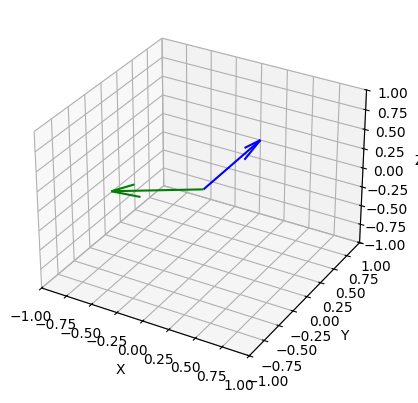

In [17]:
# Plot the rotation vectors in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tilt_R=rot_vec_R0/np.linalg.norm(rot_vec_R0)
tilt_L=rot_vec_L0/np.linalg.norm(rot_vec_L0)
ax.quiver(
    0,0,0,
    *e_R,
    color='blue', 
)

ax.quiver(
    0,0,0,
    *tilt_R,
    color='green', 
)


# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')






# scale=5
ax.axes.set_xlim3d(-1,1)
ax.axes.set_ylim3d(-1,1)
ax.axes.set_zlim3d(-1,1)


In [23]:
e_R

array([-1.61372444e-04,  9.99999919e-01,  3.69886447e-04])

In [21]:
np.dot(tilt_L,e_L)

3.469446951953614e-18

In [22]:
tilt_R

array([-9.24504468e-01, -8.19948302e-06, -3.81171207e-01])

In [ ]:
tilt_L

In [25]:
rot,_=R.align_vectors(e_R,e_L)
he=rot.as_rotvec()
np.linalg.norm(he)*180/3.14

2.0157348143228786

In [27]:
rot_2,_=R.align_vectors(rot_vec_R0,rot_vec_L0)
he_2=rot_2.as_rotvec()
np.linalg.norm(he_2)*180/3.14

74.02839728519926

(-1.0, 1.0)

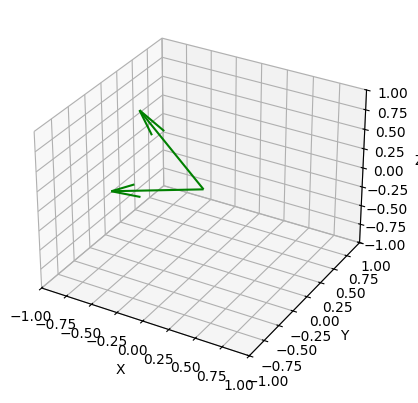

In [24]:
# Plot the rotation vectors in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

tilt_R=rot_vec_R0/np.linalg.norm(rot_vec_R0)
tilt_L=rot_vec_L0/np.linalg.norm(rot_vec_L0)
# ax.quiver(
#     0,0,0,
#     *e_R,
#     color='blue', 
# )

ax.quiver(
    0,0,0,
    *tilt_R,
    color='green', 
)


ax.quiver(
    0,0,0,
    *tilt_L,
    color='green', 
)
# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')






# scale=5
ax.axes.set_xlim3d(-1,1)
ax.axes.set_ylim3d(-1,1)
ax.axes.set_zlim3d(-1,1)

In [26]:
np.linalg.norm(rot_vec_R0)*180/3.14

0.017401880479956302

In [27]:
np.linalg.norm(rot_vec_L0)*180/3.14

1.963189711720441